# Dataset

### Import the data from kaggle

In [ ]:
import os

In [ ]:
# Dataset link ----->> https://www.kaggle.com/datasets/scribbless/another-anime-face-dataset

In [ ]:
!pip install -q kaggle

In [42]:
!mkdir .kaggle/
!cp kaggle.json ~/.kaggle/kaggle.json

In [76]:
target_dir = 'dataset/target'

In [47]:
!kaggle datasets download -d scribbless/another-anime-face-dataset
!unzip -q another-anime-face-dataset.zip -d dataset
!rm another-anime-face-dataset.zip
!mv dataset/animefaces256cleaner {target_dir}

100% 1.44G/1.44G [01:01<00:00, 25.8MB/s]
100% 1.44G/1.44G [01:01<00:00, 25.2MB/s]


In [69]:
files = [f'dataset/target/{img_name}' for img_name in os.listdir('dataset/target')]
len(files)

92219

In [70]:
files[:8]

['dataset/target/72612116_result.jpg',
 'dataset/target/71241948_result.jpg',
 'dataset/target/29606440_result.jpg',
 'dataset/target/9975507_result.jpg',
 'dataset/target/42388062_result.jpg',
 'dataset/target/45478490_result.jpg',
 'dataset/target/77966922_result.jpg',
 'dataset/target/72906690_result.jpg']

### Explore the data

In [50]:
from PIL import Image

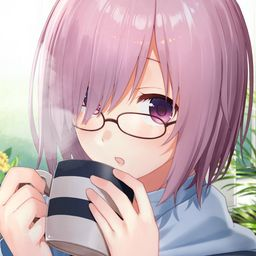

In [71]:
Image.open(files[5])

### Data preparation

In [66]:
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [53]:
def downsample(img_file, scale=0.3):
    img = cv2.imread(img_file, cv2.IMREAD_UNCHANGED)
    downsampled = cv2.resize(img, (0, 0), fx=scale, fy=scale, interpolation = cv2.INTER_NEAREST)
    return img, downsampled

In [72]:
def plot_images(images, titles, figsize, rows=1, cols=1, axes_pad=(0.1, 0.5)):
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111, nrows_ncols=(rows, cols), axes_pad=axes_pad)

    i = 0
    for ax, img in zip(grid, images):
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(titles[i])
        ax.minorticks_off()
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        i += 1

    plt.show()

In [73]:
img, downsampled = downsample(files[3], 0.5)

downsampled = cv2.resize(downsampled, (img.shape[0], img.shape[1]))

titles = ["Original", "Downsampled"]
images = [img, downsampled]

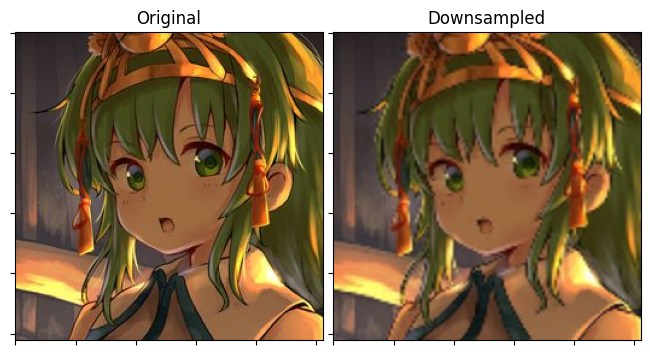

In [74]:
plot_images(images, titles, figsize=(10., 4.), cols=len(images))

In [75]:
data_dir =  'dataset/data'
if not os.path.exists(data_dir): os.makedirs(data_dir)

for file_img in files:
    img, img_small = downsample(file_img, scale=0.25)
    file_img_lr = os.path.join(data_dir, os.path.basename(file_img))
    cv2.imwrite(file_img_lr, img_small)

In [78]:
files_img_lr = [os.path.join(data_dir, x) for x in os.listdir(data_dir)]
print("High Res Images: {}, Low Res Images: {}".format(len(files), len(files_img_lr)))

High Res Images: 92219, Low Res Images: 92219


# Models Building

### Generator

In [79]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, add, BatchNormalization, Activation, LeakyReLU, Layer
from tensorflow.keras.models import Model

In [81]:
class SubpixelConv2D(Layer):

    def __init__(self, upsampling_factor=2, **kwargs):
        super(SubpixelConv2D, self).__init__(**kwargs)
        self.upsampling_factor = upsampling_factor

    def build(self, input_shape):
        last_dim = input_shape[-1]
        factor = self.upsampling_factor * self.upsampling_factor
        if last_dim % (factor) != 0:
            raise ValueError('Channel ' + str(last_dim) + ' should be of integer times of upsampling_factor^2')

    def call(self, inputs, **kwargs):
        return tf.nn.depth_to_space(inputs, self.upsampling_factor)

    def get_config(self):
        config = {'upsampling_factor': self.upsampling_factor}
        base_config = super(SubpixelConv2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        factor = self.upsampling_factor * self.upsampling_factor

        input_shape_1 = None
        if input_shape[1] is not None:
            input_shape_1 = input_shape[1] * self.upsampling_factor

        input_shape_2 = None
        if input_shape[2] is not None:
            input_shape_2 = input_shape[2] * self.upsampling_factor

        dims = [
            input_shape[0], # batch size
            input_shape_1, # h
            input_shape_2, # w
            int(input_shape[3]/factor) # channel/factor
        ]

        return tuple(dims)

In [118]:
input_shape = (64, 64, 3)
g_init = tf.random_normal_initializer(1., 0.02)
relu = Activation('relu')

input_layer = Input(shape=input_shape)
layer_past_block = Conv2D(64, 3, padding='SAME', activation='relu', kernel_initializer='HeNormal')(input_layer)
layer_initial = layer_past_block

for i in range(6):
    layer = Conv2D(64, 3, padding='SAME', kernel_initializer='HeNormal')(layer_past_block)
    layer = BatchNormalization(gamma_initializer=g_init)(layer)
    layer = add([layer_past_block, layer])
    layer_past_block = layer

layer = Conv2D(64, 3, padding='SAME', kernel_initializer='HeNormal')(layer_past_block)
layer = BatchNormalization(gamma_initializer=g_init)(layer)
layer = add([layer, layer_initial])

layer = Conv2D(256, 3, padding='SAME', kernel_initializer='HeNormal')(layer)
layer = SubpixelConv2D(upsampling_factor=2)(layer)
layer = relu(layer)

layer = Conv2D(256, 3, padding='SAME', kernel_initializer='HeNormal')(layer)
layer = SubpixelConv2D(upsampling_factor=2)(layer)
layer = relu(layer)

final_layer = Conv2D(3, 1, padding='SAME', kernel_initializer='HeNormal', activation= 'relu', )(layer)

generator = Model(inputs=input_layer, outputs=final_layer, name="generator")

In [88]:
generator_opt = tf.keras.optimizers.Adam()

### Discriminator

In [86]:
input_shape = (256, 256, 3)
g_init= tf.random_normal_initializer(1., 0.02)
l_relu= LeakyReLU(alpha= 0.2)
df_dim = 16

layer_input = Input(input_shape)

layer = Conv2D(64, 4, 2, padding='SAME', kernel_initializer='HeNormal')(layer_input)
layer = l_relu(layer)

for i in range(2, 6):
    layer = Conv2D(df_dim*(2**i), 4, 2, padding='SAME', kernel_initializer='HeNormal')(layer)
    layer = l_relu(layer)
    layer = BatchNormalization(gamma_initializer=g_init)(layer)

layer = Conv2D(df_dim*16, 1, 1, padding='SAME', kernel_initializer='HeNormal')(layer)
layer = l_relu(layer)
layer = BatchNormalization(gamma_initializer=g_init)(layer)

layer = Conv2D(df_dim*8, 1, 1, padding='SAME', kernel_initializer='HeNormal')(layer)
layer = BatchNormalization(gamma_initializer=g_init)(layer)
layer_past = layer

layer = Conv2D(df_dim*4, 3, 1, padding='SAME', kernel_initializer='HeNormal')(layer)
layer = l_relu(layer)
layer = BatchNormalization(gamma_initializer=g_init)(layer)

layer = Conv2D(df_dim*8, 3, 1, padding='SAME', kernel_initializer='HeNormal')(layer)
layer = BatchNormalization(gamma_initializer= g_init)(layer)

layer = add([layer, layer_past])

layer = Flatten()(layer)
layer_final = Dense(units=1, kernel_initializer='HeNormal', activation= 'sigmoid')(layer)

discriminator = Model(inputs=layer_input, outputs=layer_final, name="discriminator")

In [89]:
discriminator_opt = tf.keras.optimizers.Adam()

Feature Vector Creator (VGG19)

In [87]:
vgg = tf.keras.applications.VGG19(include_top=False)

input_layer = Input(shape=input_shape)
layer = vgg.layers[0](input_layer)

for layer_vgg in vgg.layers[1:17]: layer = layer_vgg(layer)

vgg = Model(inputs=input_layer, outputs=layer, name='vgg')

# Data Loading

In [92]:
dataset_lr = tf.keras.utils.image_dataset_from_directory(data_dir, labels=None, image_size=(64, 64), batch_size=16, shuffle=False)
dataset_hr = tf.keras.utils.image_dataset_from_directory(target_dir, labels=None, image_size=(256, 256), batch_size=16, shuffle=False)
dataset = zip(dataset_lr, dataset_hr)

Found 92219 files belonging to 1 classes.
Found 92219 files belonging to 1 classes.


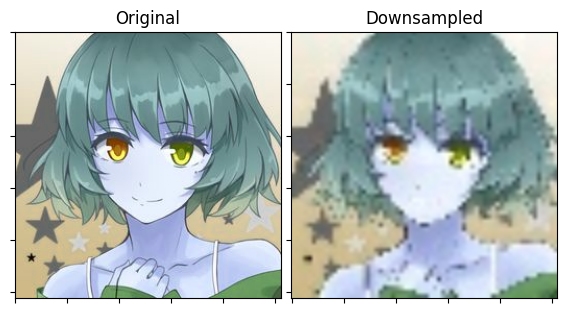

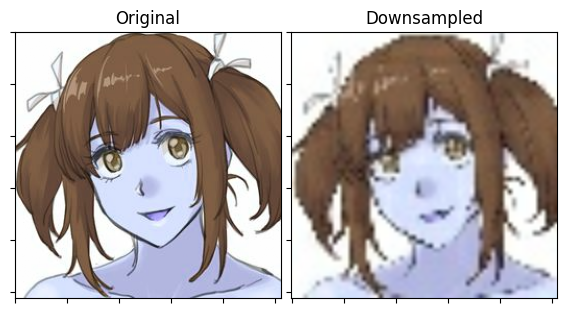

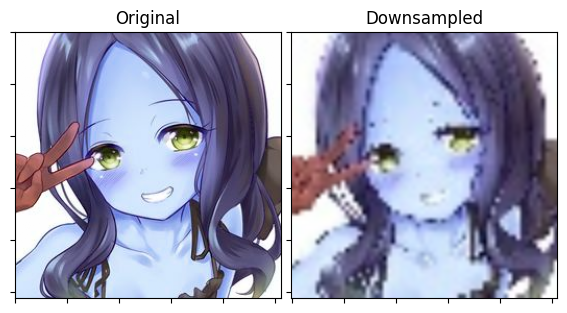

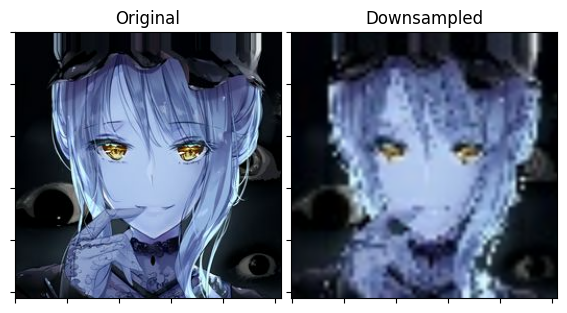

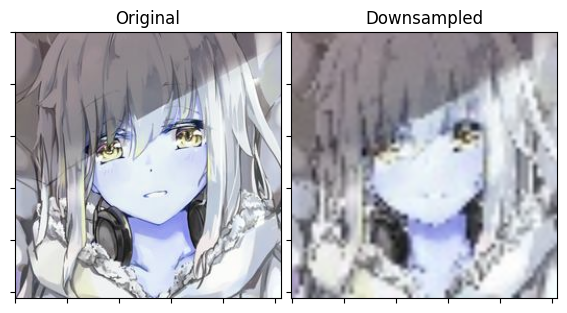

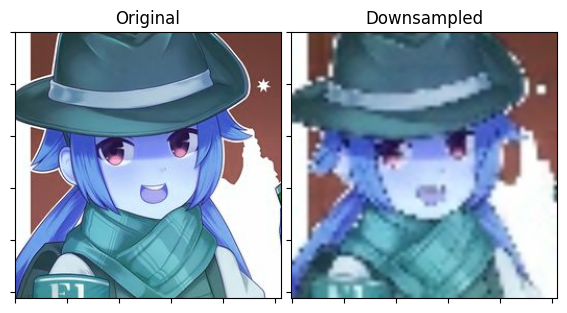

In [95]:
i = 0
for img_batch_lr, img_batch_hr in dataset:

    img_hr = img_batch_hr[0].numpy()/255
    img_lr = img_batch_lr[0].numpy()/255

    img_lr_resize = cv2.resize(img_lr, (img_hr.shape[0], img_hr.shape[1]))
    # cv2_imshow(np.hstack([img_hr, img_lr_resize]))
    plot_images([img_hr, img_lr_resize], ["Original", "Downsampled"], (7, 4), rows=1, cols=2)

    if i == 5: break
    i += 1

# Training

### Initialize Generator

In [96]:
import numpy as np

In [98]:
epochs = 10
steps_per_epoch = 500

img_save_dir = "Results"
# checkpoint_dir = "Models"

In [99]:
if not os.path.exists(img_save_dir): os.mkdir(img_save_dir)
# if not os.path.exists(checkpoint_dir): os.mkdir(checkpoint_dir)

In [120]:
g_optimizer_init = tf.keras.optimizers.Adam()

for epoch in range(epochs):
    if epoch == 4: break
    for step, (X, Y) in enumerate(dataset):

        if step > steps_per_epoch: break

        with tf.GradientTape() as tape:
            Y_pred = generator(X)

            mse_loss = tf.reduce_mean(tf.reduce_mean(tf.math.squared_difference(Y, Y_pred), axis=-1))
            grad = tape.gradient(mse_loss, generator.trainable_weights)
            g_optimizer_init.apply_gradients(zip(grad, generator.trainable_weights))

        if step % 100 == 0:
            print("Epoch/Step: [{}/{}], MSE: {:.3f} ".format(epoch+1, step, mse_loss))

        if step == 0:
            img = generator.predict(X[0:1])[0]
            img = Image.fromarray(np.uint8(img))
            img.save(os.path.join(img_save_dir, '{}_g_init.png'.format(epoch+1)))

    print()

Epoch/Step: [1/0], MSE: 27496976.000 
1/1 [==============================] - 0s 168ms/step
Epoch/Step: [1/100], MSE: 33387.383 
Epoch/Step: [1/200], MSE: 34753.441 
Epoch/Step: [1/300], MSE: 33947.598 
Epoch/Step: [1/400], MSE: 29712.156 
Epoch/Step: [1/500], MSE: 29005.307 

Epoch/Step: [2/0], MSE: 31563.625 
1/1 [==============================] - 0s 28ms/step
Epoch/Step: [2/100], MSE: 30677.334 
Epoch/Step: [2/200], MSE: 33538.055 
Epoch/Step: [2/300], MSE: 32595.777 
Epoch/Step: [2/400], MSE: 29171.074 
Epoch/Step: [2/500], MSE: 34058.168 

Epoch/Step: [3/0], MSE: 31785.055 
1/1 [==============================] - 0s 18ms/step
Epoch/Step: [3/100], MSE: 28488.754 
Epoch/Step: [3/200], MSE: 31225.283 
Epoch/Step: [3/300], MSE: 30442.814 
Epoch/Step: [3/400], MSE: 32815.418 




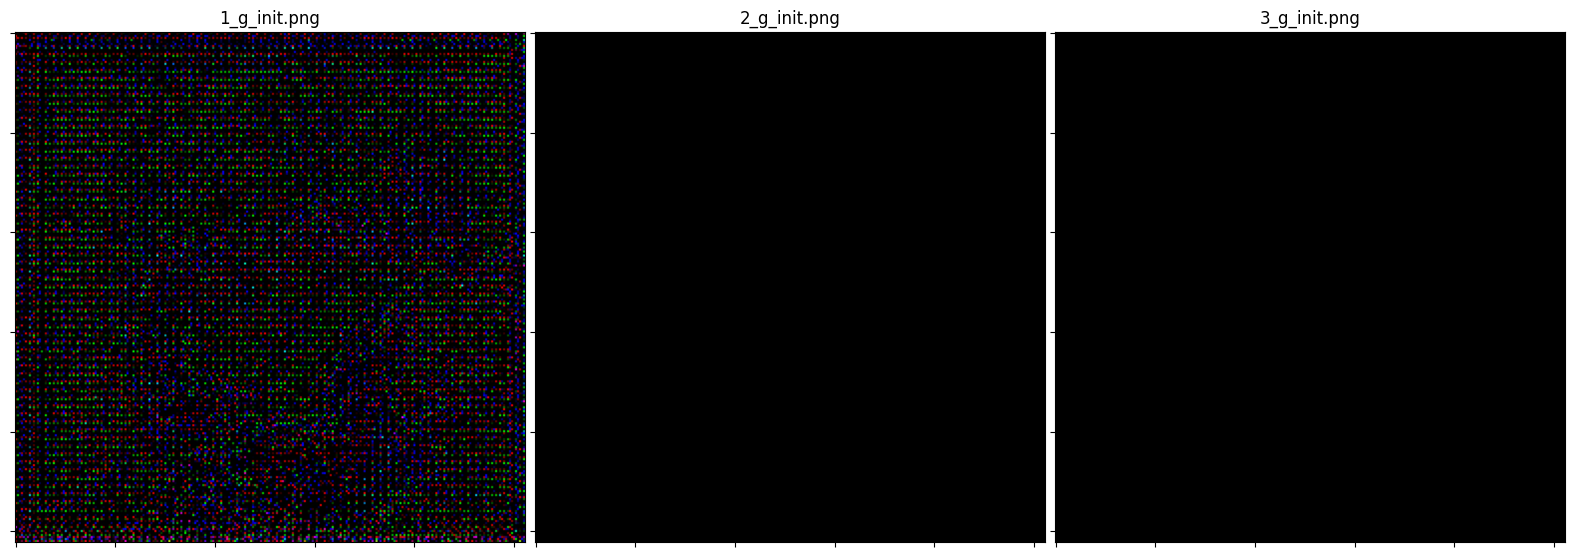

In [122]:
sample_images_filepaths = [os.path.join(img_save_dir, x) for x in os.listdir(img_save_dir)]
sample_images_filepaths = list(filter(lambda x : '_g_init' in x, sample_images_filepaths))
sample_images_filepaths.sort(key = lambda x: x.split('_')[0])

images = [cv2.imread(x) for x in sample_images_filepaths]
titles = [os.path.basename(x) for x in sample_images_filepaths]

plot_images(images, titles, figsize=(20., 8.), rows=1, cols=len(images))

### Training

In [125]:
for epoch in range(epochs):
    for step, (X, Y) in enumerate(dataset):

        if step > steps_per_epoch: break

        with tf.GradientTape(persistent=True) as tape:
            fake_img = generator(X)
            fake_logits = discriminator(fake_img)
            real_logits = discriminator(Y)
            fake_feature = vgg(fake_img)
            real_feature = vgg(Y)

            # Discriminator. loss
            d_loss1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(fake_logits, tf.zeros_like(fake_logits)))
            d_loss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(real_logits, tf.ones_like(real_logits)))
            d_loss = d_loss1 + d_loss2

            # Generator. loss
            g_gan_loss = 2e-3 * tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(fake_logits, tf.ones_like(fake_logits)))
            mse_loss   = 2e-1 * tf.reduce_mean(tf.reduce_mean(tf.math.squared_difference(fake_img, Y), axis=-1))
            vgg_loss   = 2e-6 * tf.reduce_mean(tf.reduce_mean(tf.math.squared_difference(fake_feature, real_feature), axis=-1)) #is used to calculate the mean value of the VGG loss across the batch.
            g_loss = mse_loss + vgg_loss + g_gan_loss

            grad = tape.gradient(g_loss, generator.trainable_weights)
            generator_opt.apply_gradients(zip(grad, generator.trainable_weights))

            grad = tape.gradient(d_loss, discriminator.trainable_weights)
            discriminator_opt.apply_gradients(zip(grad, discriminator.trainable_weights))

        if step % 100 == 0:
            print("Epoch/Step: [{}/{}]: D.loss: {:.3f}: G.loss: {:.3f}".format(epoch+1, step , d_loss, g_loss))

        if step == 0:
            img = generator.predict(X[0:1])[0]
            img = Image.fromarray(np.uint8(img))
            img.save(os.path.join(img_save_dir, '{}_g_train.png'.format(epoch)))

    print()